# Introduction To Numerical Mutual Information Tests

In this notebook, we use the numerical probability generation functions tested in "Probability_Distribution_Tests", generate several relevant joint probability distributions and test their properties. It contains:

- Example Probability Calculation
- Normalization Checks
- Mutual Information Checks

In [9]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from binary_markov_funcs import two_state_system_dt, two_state_system_detection_dt

# Simulation parameters
initial_p = np.array([1.0, 0.0])  # Start in OFF state
k_on = 1.0
k_off = 1.0
alpha = 5.0

t_max = 30.0  # Total simulation time
dt = 0.01  # Time step size (user can adjust)
t_eval = np.arange(0, t_max, dt)
num_time_points = len(t_eval)

# Run simulation and save
solution = solve_ivp(two_state_system_dt, [0, t_max], initial_p, 
                    t_eval=t_eval, method='RK45', args=(k_off, k_on))
steady_state = solution.y[:, -1]  # Final probabilities
np.save('steady_state.npy', steady_state) # SAVE THE STEADY STATE SOLUTION

# The initial steady state conditioned on a detectable event occuring
state_indices = np.arange(steady_state.shape[0])  # [0, 1, 2, ...]
weighted_init_norm_factors = np.sum(steady_state * state_indices, keepdims=True)
# Safe division (skip where denominator is zero)
with np.errstate(divide='ignore', invalid='ignore'):
    normalized_init_state = (steady_state * state_indices) / weighted_init_norm_factors
    normalized_init_state = np.nan_to_num(normalized_init_state)  # Convert NaN/inf to 0
np.save('steady_state_with_detection.npy', normalized_init_state) # SAVE THE STEADY STATE SOLUTION

# Run detection simulation for each initial condition
num_states = 2  # Number of initial states in the system (user specifies this)
solution = np.zeros((num_states, num_time_points, num_states))

for initial_state in range(num_states):
    # Create initial condition (100% in current state)
    initial_p = np.zeros(num_states)
    initial_p[initial_state] = 1.0
    
    # Solve ODE system
    sol = solve_ivp(two_state_system_detection_dt, [0, t_max], initial_p, 
                   t_eval=t_eval, method='RK45', args=(k_off, k_on, alpha))
    # Store solution in array (solution[initial_state, time_index, state_value])
    solution[initial_state, :, :] = sol.y.T
np.save('ode_solutions.npy', solution) # SAVE THE ODE SOLUTION

# Normalize each initial condition's solution, to find the probability of randomly observing
# a particular time since the last event and the current state
normalized_solution = np.zeros_like(solution)
for initial_state in range(solution.shape[0]):
    # Sum over states for each time point (keep dimensions for broadcasting)
    norm_factors = np.sum(solution[initial_state]*dt)
    normalized_solution[initial_state] = solution[initial_state] / norm_factors
np.save('time_since_last_event.npy', normalized_solution)

# Create marginalized array by summing over x values (axis=2)
marginalized = np.sum(solution, axis=2)  # Shape: [initial_conditions, time_points]
# Compute death probability density (negative time derivative of S)
death_prob = -np.diff(marginalized, axis=1) / dt  # Finite difference derivative
# Pad with zero to match original array size
death_prob = np.pad(death_prob, ((0,0),(0,1)), mode='constant') #Shape: [initial_conditions, time_points]
np.save('death_probs.npy', death_prob) # SAVE THE PROBABILITY OF DEATH AT TIME INDEX GIVEN INITIAL CONDITION 

# Create state indices array for weighting
state_indices = np.arange(solution.shape[2])  # [0, 1, 2, ...]
# Compute weighted sum (expectation value), to normalize by the probability of the current x given t and init
weighted_norm_factors = np.sum(solution * state_indices, axis=2, keepdims=True)
# Safe division (skip where denominator is zero)
with np.errstate(divide='ignore', invalid='ignore'):
    normalized_solution = (solution * state_indices) / weighted_norm_factors
    normalized_solution = np.nan_to_num(normalized_solution)  # Convert NaN/inf to 0
np.save('prob_x_given_t_and_init.npy', normalized_solution) # SAVE THE PROBABILITY OF X given a reaction time and initial condition 

print ("Done producing the relevant pdfs!")

Done producing the relevant pdfs!


### Loading Generated PDFs

In [10]:
import numpy as np
# With our code, we now want to generate the probability distribution
# Load each array
steady_state = np.load('steady_state.npy')
steady_state_with_detection = np.load('steady_state_with_detection.npy')
ode_solutions = np.load('ode_solutions.npy')
time_since_last_event = np.load('time_since_last_event.npy')
death_probs = np.load('death_probs.npy')
prob_x_given_t_and_init = np.load('prob_x_given_t_and_init.npy')

# Now you can use these arrays in your code
print("Steady state solution shape:", steady_state.shape)
print("Steady state with detection:", steady_state_with_detection)
print("ODE solutions shape:", ode_solutions.shape)
print("Time since last event shape:", time_since_last_event.shape)
print("Death probabilities shape:", death_probs.shape)
print("Probability of X given t and init shape:", prob_x_given_t_and_init.shape)

Steady state solution shape: (2,)
Steady state with detection: [0. 1.]
ODE solutions shape: (2, 3000, 2)
Time since last event shape: (2, 3000, 2)
Death probabilities shape: (2, 3000)
Probability of X given t and init shape: (2, 3000, 2)


# Example Probability Calculation

From our original numerical solution, we can obtain PDFs relevant to the mutual information of interest with the following functions.

In [11]:
def numerical_prob_x_t_xi(init_cond, time_index, current_x, steady_state_with_detection, time_since_last_event):
    return steady_state_with_detection[init_cond] * time_since_last_event[init_cond, time_index, current_x]

def numerical_prob_x_t_given_xi(init_cond, time_index, current_x, time_since_last_event):
    return time_since_last_event[init_cond, time_index, current_x]
    
# Imagine we want to the probability distribution of (init cond, time index, time index2, current state)
# Then we need steady state with detection[init cond] * death_probs[init cond, time index2] * 
# sum over intermediate x of prob_x_given_t_and_init[init cond, time index2, intermediate x]*
# time_since_last_event[intermediate x, time index, current state]
def numerical_prob_x_t_t2_xi(init_cond, time_index, time_index2, current_x, steady_state_with_detection,
                             time_since_last_event, death_probs, prob_x_given_t_and_init, num_x_states):
    prob = steady_state_with_detection[init_cond]*death_probs[init_cond, time_index2]
    intermediate_sum = 0
    for intermediate_value in range(1, num_x_states):
        intermediate_sum += prob_x_given_t_and_init[init_cond, time_index2, intermediate_value]*time_since_last_event[intermediate_value, time_index, current_x]
    return prob*intermediate_sum

# Given we know the initial condition, we want the probability of that a molecular death event occurs at time index t
# and results in a state end_x. This is given by death_probs[init_cond, time_index] * prob_x_given_t_and_init[init_cond, time_index, end_x]
def numerical_prob_deathevent_x_t_conditioned_xi(init_cond, time_index, end_x, death_probs, prob_x_given_t_and_init):
    return death_probs[init_cond, time_index] * prob_x_given_t_and_init[init_cond, time_index, end_x]

An example of our numerical algorithms results vs the analytical solution from earlier.

In [20]:
from binary_markov_funcs import two_state_analytical_solution, two_state_markov_pdfgen

print (numerical_prob_x_t_xi(1, 5, 1, steady_state_with_detection, time_since_last_event))
joint_prob, survival_time_prob, x_steady_probs = two_state_markov_pdfgen(k_on, k_off, alpha, t_eval)
#Note that our analytical joint probability distribution ignores the probability of initial state = 0
#So it's shape is [current_x, time_index]
print (joint_prob[1, 5]) 

1.8313434183775188
1.831482452040721


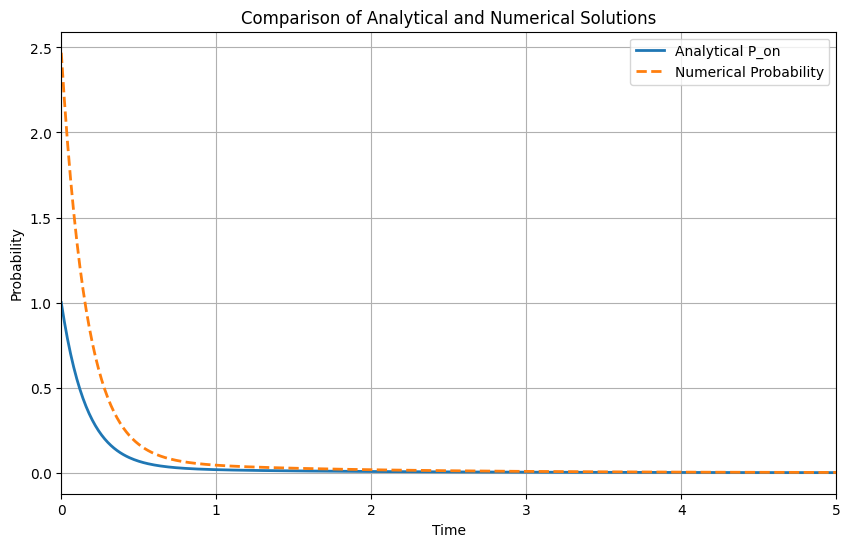

In [17]:
# Evaluate for multiple time indices
indices = np.arange(len(t_eval))  # Use all time points or select a range

# Calculate numerical probabilities
numerical_probs = np.array([numerical_prob_x_t_xi(1, i, 1, steady_state_with_detection, time_since_last_event) 
                           for i in indices])

# Get analytical solution (assuming you've already computed this)
P_on, P_off = two_state_analytical_solution(k_on, k_off, alpha, t_eval)

# Plot both results
plt.figure(figsize=(10, 6))
plt.plot(t_eval[indices], P_on[indices], label='Analytical P_on', linewidth=2)
plt.plot(t_eval[indices], numerical_probs, '--', label='Numerical Probability', linewidth=2)
plt.xlim([0, 5])
plt.xlabel('Time')
plt.ylabel('Probability')
plt.title('Comparison of Analytical and Numerical Solutions')
plt.legend()
plt.grid(True)
plt.show()

Two methods of computing probabilities associated with multiple time-steps.

In [10]:
print (numerical_prob_x_t_t2_xi(1, 5, 5, 1, steady_state_with_detection, time_since_last_event, death_probs, prob_x_given_t_and_init, 2))

#Alternate way of getting the probability (x, t_1, t_2, x_i):
#Compute P_death at(x_middle, t_2, x_i) * P_survival(x, t_1, x_middle)
#and sum over all the middle x values, which in this case we can skip cause they're 0!
P_death = numerical_prob_deathevent_x_t_conditioned_xi(1, 5, 1, death_probs, prob_x_given_t_and_init)
P_survival_given_xmed = time_since_last_event[1, 5, 1]
prob_x_t_t2_xi = steady_state_with_detection[1]*P_death*P_survival_given_xmed
print (prob_x_t_t2_xi)

1.4564777222283607


## Normalization Checks

Our final probability distributions should be normalized. We'll compute the norm.

In [13]:
total_prob = 0
for time_index in range(len(t_eval)):
    for current_x in range(2):
        for init_cond in range(1, 2):
            total_prob += numerical_prob_x_t_xi(init_cond, time_index, current_x, steady_state_with_detection, time_since_last_event)*dt
print (total_prob)

0.9999999999999952


We also check for the normalization of the two-step mutual information.

In [13]:
total_prob = 0
for time_index in range(len(t_eval)):
    for time_index2 in range(len(t_eval)):
        for current_x in range(2):
            for init_cond in range(1, 2):
                total_prob += numerical_prob_x_t_t2_xi(init_cond, time_index, time_index2, current_x, steady_state_with_detection,
                             time_since_last_event, death_probs, prob_x_given_t_and_init, 2)*dt*dt
print (total_prob)

0.9999998589383947


The normalization is approximately 1, as expected.

# Mutual Information Checks

We check the results of our numerical approach for computing the mutual information agree with our analytical results.

In [14]:
joint_entropy = 0
time_entropy = 0

for time_index in range(len(t_eval)):
    prob_t = 0
    for current_x in range(2):
        prob_x_t = 0
        for init_cond in range(1, 2):
            prob_x_t_xi = numerical_prob_x_t_xi(init_cond, time_index, current_x, steady_state_with_detection, time_since_last_event)
            prob_x_t += prob_x_t_xi
        if prob_x_t > 0:
            joint_entropy += -prob_x_t * np.log2(prob_x_t)*dt
        prob_t += prob_x_t
    if prob_t > 0:
        time_entropy += -prob_t * np.log2(prob_t)*dt

print ("The joint entropy is ", joint_entropy)
print ("The time entropy is ", time_entropy)
print ("The difference is ", joint_entropy - time_entropy)

The joint entropy is  1.820339767487756
The time entropy is  1.169081732684137
The difference is  0.651258034803619


In [15]:
# Comparison with analytics
from binary_markov_funcs import mutual_information_calc
mutual_information, joint_entropy, survival_time_entropy, x_entropy = mutual_information_calc(k_on, k_off, alpha, t_eval, dt)
print ("The joint entropy is ", joint_entropy)
print ("The time entropy is ", time_entropy)
print ("The difference is ", joint_entropy - time_entropy)

The joint entropy is  1.8199501608144943
The time entropy is  1.169081732684137
The difference is  0.6508684281303574


## Multi-Step Entropy Calculation

We also check a multi-step entropy calculation, noting that the mutual information should be the same as the single step (which can be shown explicitly from the factorization of the PDF). 

In [16]:
joint_entropy = 0
time_entropy = 0

for time_index in range(len(t_eval)):
    for time_index2 in range(len(t_eval)):
        prob_t = 0
        for current_x in range(2):
            prob_x_t = 0
            for init_cond in range(1, 2):
                prob_x_t_xi = numerical_prob_x_t_t2_xi(init_cond, time_index, time_index2, current_x, steady_state_with_detection,
                             time_since_last_event, death_probs, prob_x_given_t_and_init, 2)
                prob_x_t += prob_x_t_xi
            if prob_x_t > 0:
                joint_entropy += -prob_x_t * np.log2(prob_x_t)*dt*dt
            prob_t += prob_x_t
        if prob_t > 0:
            time_entropy += -prob_t * np.log2(prob_t)*dt*dt
    if time_index %500 == 0:
        print ("Time index ", time_index)
print ("The joint entropy is ", joint_entropy)
print ("The time entropy is ", time_entropy)
print ("The difference is ", joint_entropy - time_entropy)

Time index  0
Time index  500
Time index  1000
Time index  1500
Time index  2000
Time index  2500
4.124537243296322   3.302864436617181
0.8216728066791408


We find good agreement between the mutual information in all three computations, as expected. 

Next steps: turn these into nice example functions and use them to generate N vs Alpha. Also create functions to generate the upper bound and lower bound for more complex systems.

Then finally a Poisson type upstream.